In [2]:
# notebooks/04_passenger_forecasting_modeling.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder # If adding non-time categorical features
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer # If mixing time features with other types
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Model Algorithm (Example: XGBoost Regressor for time series)
import xgboost as xgb

# Holiday library (optional, but very useful for passenger forecasting)

import holidays

# --- Configuration ---
MODEL_NAME_PREFIX = "passenger_daily_total" # Forecasting total daily passengers
TARGET_COLUMN = "TotalDailyPassengers" # Our NEW aggregated target
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)



# CRISP-DM Phase: Data Understanding & Preparation


--- Aggregating to Daily Passenger Totals ---
Daily passenger data shape: (366, 1)
            TotalDailyPassengers
Date                            
2024-01-01                  5795
2024-01-02                  5895
2024-01-03                  5846
2024-01-04                  6182
2024-01-05                  5956


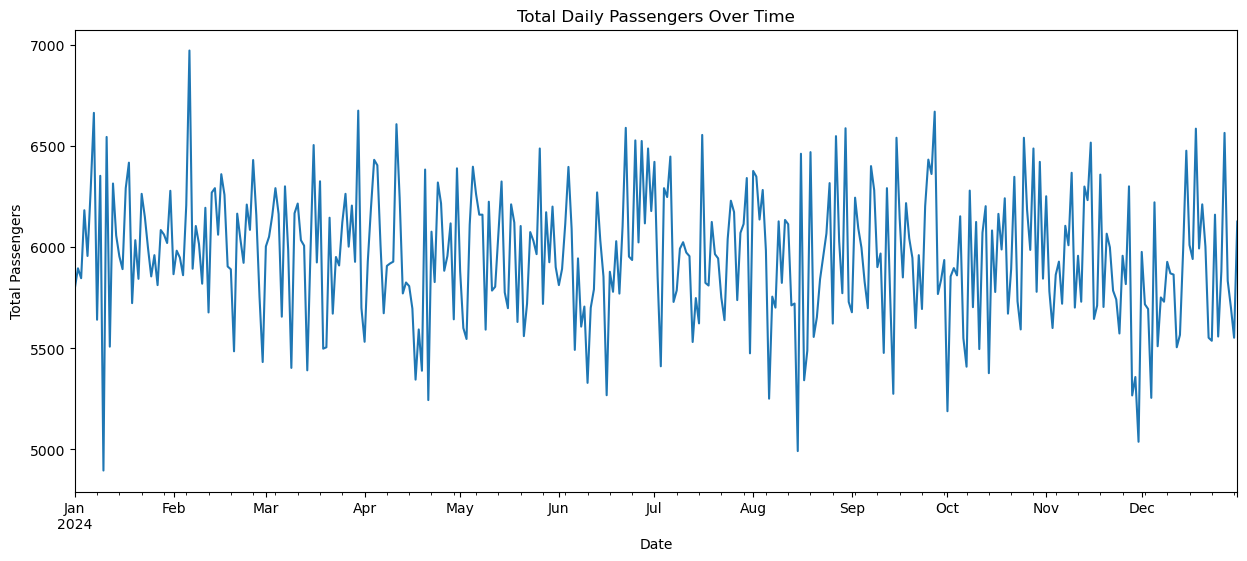


--- Feature Engineering for Time Series ---
Shape after creating time series features and dropping NaNs: (336, 21)

Identified Numerical Features: ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'Is_Weekend', 'Time_Trend', 'Is_Holiday', 'Lag_1_Days', 'Lag_2_Days', 'Lag_3_Days', 'Lag_7_Days', 'Lag_14_Days', 'Lag_30_Days', 'Rolling_Mean_7_Days', 'Rolling_Std_7_Days', 'Rolling_Mean_14_Days', 'Rolling_Std_14_Days']

Training set shape: X_train=(268, 20), y_train=(268,)
Test set shape: X_test=(68, 20), y_test=(68,)


In [3]:

# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df_flights = df_raw.copy()
df_flights.columns = df_flights.columns.str.strip()

# 2. Aggregate Data to Daily Passenger Totals
print("\n--- Aggregating to Daily Passenger Totals ---")
if 'ScheduledTime' not in df_flights.columns or 'Passengers' not in df_flights.columns:
    raise ValueError("Required columns 'ScheduledTime' and 'Passengers' not found for aggregation.")

df_flights['ScheduledTime'] = pd.to_datetime(df_flights['ScheduledTime'], errors='coerce')
df_flights.dropna(subset=['ScheduledTime', 'Passengers'], inplace=True) # Need these for aggregation

df_flights['FlightDate'] = df_flights['ScheduledTime'].dt.date # Extract date part
daily_passengers_df = df_flights.groupby('FlightDate')['Passengers'].sum().reset_index()
daily_passengers_df.rename(columns={'Passengers': TARGET_COLUMN, 'FlightDate': 'Date'}, inplace=True)
daily_passengers_df['Date'] = pd.to_datetime(daily_passengers_df['Date']) # Ensure Date is datetime
daily_passengers_df = daily_passengers_df.sort_values(by='Date').set_index('Date')



print(f"Daily passenger data shape: {daily_passengers_df.shape}")
print(daily_passengers_df.head())

plt.figure(figsize=(15,6))
daily_passengers_df[TARGET_COLUMN].plot()
plt.title('Total Daily Passengers Over Time')
plt.ylabel('Total Passengers')
plt.show()

# 3. Feature Engineering for Time Series
print("\n--- Feature Engineering for Time Series ---")
df_ts = daily_passengers_df.copy()

df_ts['Year'] = df_ts.index.year
df_ts['Month'] = df_ts.index.month
df_ts['Day'] = df_ts.index.day
df_ts['DayOfWeek'] = df_ts.index.dayofweek # Monday=0, Sunday=6
df_ts['DayOfYear'] = df_ts.index.dayofyear
df_ts['WeekOfYear'] = df_ts.index.isocalendar().week.astype(int) # .week can be object, ensure int
df_ts['Quarter'] = df_ts.index.quarter
df_ts['Is_Weekend'] = df_ts['DayOfWeek'].isin([5, 6]).astype(int)
df_ts['Time_Trend'] = np.arange(len(df_ts)) # Simple linear time trend


country_holidays = holidays.US(years=df_ts.index.year.unique()) # Or your specific country


df_ts['Is_Holiday'] = df_ts.index.to_series().apply(lambda date: int(date in country_holidays)).values


for lag in lags_to_create:
    df_ts[f'Lag_{lag}_Days'] = df_ts[TARGET_COLUMN].shift(lag)

# Rolling Window Features (e.g., average passengers over last 7 days)
rolling_windows = [7, 14]
for window in rolling_windows:
    df_ts[f'Rolling_Mean_{window}_Days'] = df_ts[TARGET_COLUMN].shift(1).rolling(window=window).mean() # shift(1) to avoid using current day's target
    df_ts[f'Rolling_Std_{window}_Days'] = df_ts[TARGET_COLUMN].shift(1).rolling(window=window).std()

# Drop rows with NaNs created by lags/rolling windows
df_ts.dropna(inplace=True)
print(f"Shape after creating time series features and dropping NaNs: {df_ts.shape}")

# Define X and y
y = df_ts[TARGET_COLUMN]
X = df_ts.drop(columns=[TARGET_COLUMN])

# 4. Identify Feature Types (all should be numerical now for this approach)
# If you had other categorical features (e.g., 'SpecialEvent_Type'), they'd be handled here.
numerical_features_ts = X.columns.tolist()
categorical_features_ts = [] # None for this purely time-based feature set, unless you add some

print(f"\nIdentified Numerical Features: {numerical_features_ts}")

# 5. Split Data (Time Series Aware)

split_point = int(len(X) * 0.8) # 80% for training
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]



print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")


# 6. Create Preprocessing Pipelines (Simpler if all features are numerical)

numerical_pipeline_ts = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Mean or median, or more sophisticated for time series
    ('scaler', StandardScaler())
])

# Since all features are numerical in this example setup:
preprocessor_ts = numerical_pipeline_ts # The pipeline itself is the preprocessor



# CRISP-DM Phase: Modeling

In [4]:
# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed = preprocessor_ts.fit_transform(X_train) # Returns NumPy array
X_train_processed_df = pd.DataFrame(X_train_processed, columns=X_train.columns, index=X_train.index) # Convert back to DataFrame
print(f"Shape of X_train_processed: {X_train_processed_df.shape}")

# Transform the Test Data
X_test_processed = preprocessor_ts.transform(X_test) # Returns NumPy array
X_test_processed_df = pd.DataFrame(X_test_processed, columns=X_test.columns, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed_df.shape}")

# Save the list of feature names used by the preprocessor
# (which are just X_train.columns before scaling in this simplified case)
feature_names_processed_ts = X_train.columns.tolist()


# 8. Define and Train the Model (XGBoost Regressor)
print("\n--- Model Training ---")
xgb_reg_pass = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,      # More estimators can be good for time series
    learning_rate=0.05,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
    # Consider adding 'monotone_constraints' if some features should only have positive/negative impact
)

xgb_reg_pass.fit(X_train_processed_df, y_train)
print("Model training complete.")



--- Fitting Preprocessor ---
Shape of X_train_processed: (268, 20)
Shape of X_test_processed: (68, 20)

--- Model Training ---
Model training complete.


#  CRISP-DM Phase: Evaluation


--- Model Evaluation ---

--- Training Set Metrics (Passenger Forecast) ---
R-squared (R2): 0.9978
Mean Absolute Error (MAE): 10.81
Root Mean Squared Error (RMSE): 15.01
Mean Absolute Percentage Error (MAPE): 0.18%

--- Test Set Metrics (Passenger Forecast) ---
R-squared (R2): -0.1853
Mean Absolute Error (MAE): 280.47
Root Mean Squared Error (RMSE): 364.58
Mean Absolute Percentage Error (MAPE): 4.82%


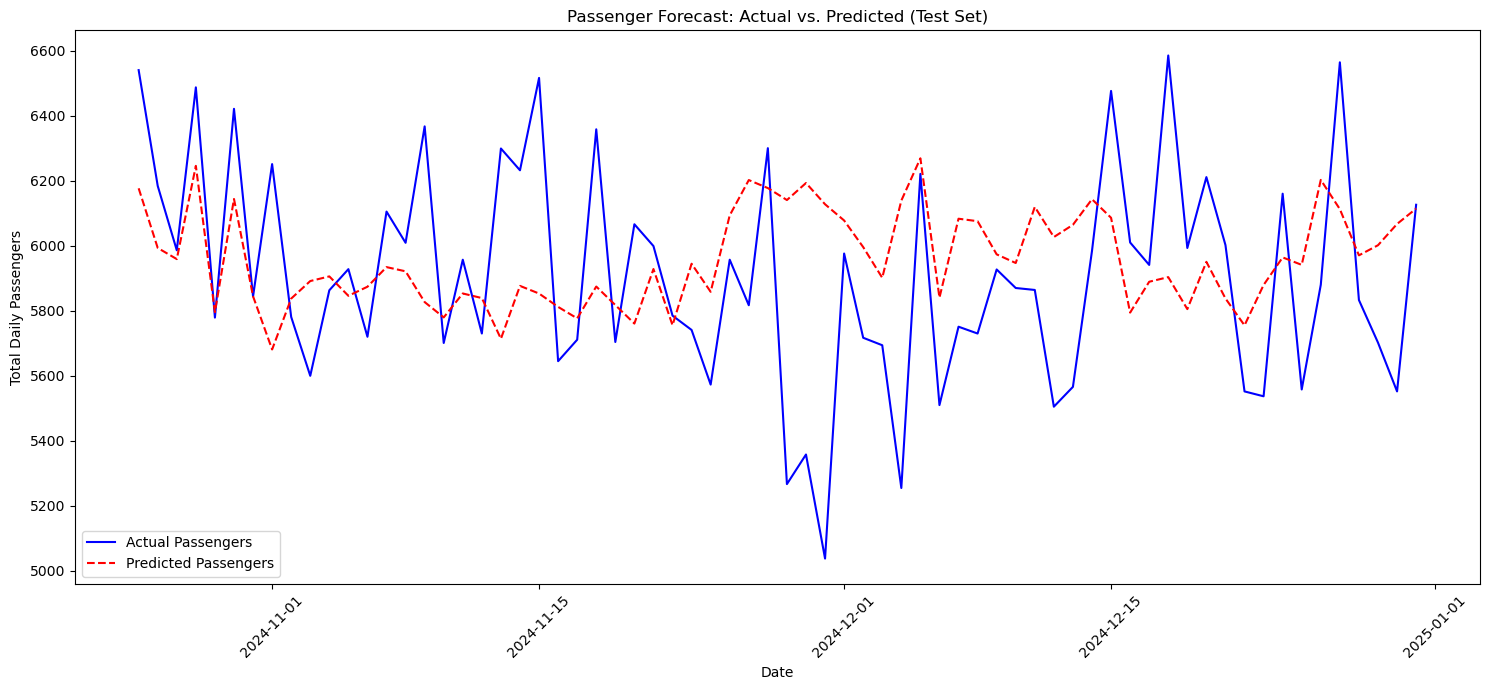

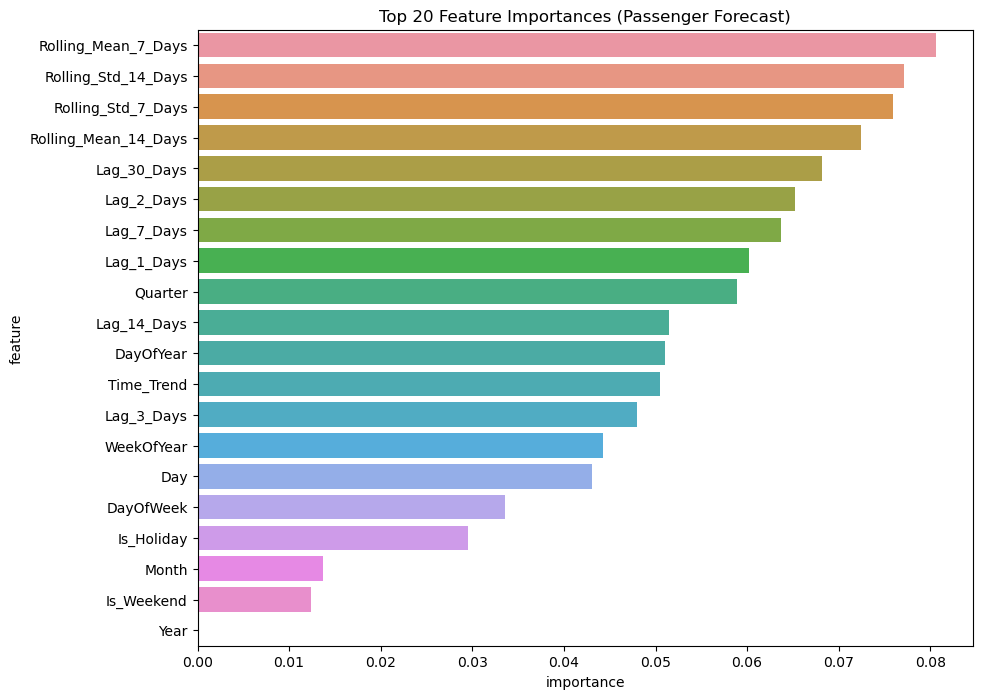

In [5]:
print("\n--- Model Evaluation ---")
y_pred_train_pass = xgb_reg_pass.predict(X_train_processed_df)
y_pred_test_pass = xgb_reg_pass.predict(X_test_processed_df)

# Ensure predictions are non-negative
y_pred_train_pass = np.maximum(0, y_pred_train_pass)
y_pred_test_pass = np.maximum(0, y_pred_test_pass)


print("\n--- Training Set Metrics (Passenger Forecast) ---")
print(f"R-squared (R2): {r2_score(y_train, y_pred_train_pass):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train, y_pred_train_pass):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, y_pred_train_pass)):.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_train, y_pred_train_pass)*100:.2f}%")


print("\n--- Test Set Metrics (Passenger Forecast) ---")
print(f"R-squared (R2): {r2_score(y_test, y_pred_test_pass):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test_pass):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_test_pass)):.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred_test_pass)*100:.2f}%")


# Plotting actual vs. predicted for the test set
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Passengers', color='blue')
plt.plot(y_test.index, y_pred_test_pass, label='Predicted Passengers', color='red', linestyle='--')
plt.title('Passenger Forecast: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Total Daily Passengers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Importance
if hasattr(xgb_reg_pass, 'feature_importances_'):
    importances_pass = xgb_reg_pass.feature_importances_
    feature_importance_df_pass = pd.DataFrame({'feature': feature_names_processed_ts, 'importance': importances_pass})
    feature_importance_df_pass = feature_importance_df_pass.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_pass)
    plt.title('Top 20 Feature Importances (Passenger Forecast)')
    plt.show()


#  CRISP-DM Phase: Deployment (Saving Artifacts) 

In [6]:

print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor (which is the numerical_pipeline_ts in this case)
preprocessor_filename_pass = f"preprocessor_{MODEL_NAME_PREFIX}.pkl"
preprocessor_path_pass = os.path.join(MODELS_META_DIR, preprocessor_filename_pass)
joblib.dump(preprocessor_ts, preprocessor_path_pass)
print(f"Preprocessor saved to: {preprocessor_path_pass}")

# 2. Save the list of Feature Names (these are the columns of X_train before scaling)
feature_names_filename_pass = f"feature_names_{MODEL_NAME_PREFIX}.pkl"
feature_names_path_pass = os.path.join(MODELS_META_DIR, feature_names_filename_pass)
joblib.dump(feature_names_processed_ts, feature_names_path_pass) # Save the list of names
print(f"Feature names saved to: {feature_names_path_pass}")

# 3. Save the Trained Model
final_model_name_for_dashboard_pass = "passenger_volume_forecaster.pkl"
model_path_pass = os.path.join(MODELS_DIR, final_model_name_for_dashboard_pass)
joblib.dump(xgb_reg_pass, model_path_pass)
print(f"Trained model saved to: {model_path_pass}")

print("\n--- Passenger Volume Forecasting (Daily Total) Modeling Notebook Complete ---")


--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_passenger_daily_total.pkl
Feature names saved to: ../models_meta/feature_names_passenger_daily_total.pkl
Trained model saved to: ../models/passenger_volume_forecaster.pkl

--- Passenger Volume Forecasting (Daily Total) Modeling Notebook Complete ---
